# Training procedure for the SLADS-Net algorithm (which is the backend of FAST)

The training procedure can be essentially summarized in two steps:
1. Generate a database of feature vectors and labels
2. Train and validate the neural network

One complication here is that the "reduction in distortion" (RD) used as the training labels depends on a user-defined parameter $c$. As such, we need to generate separate labels for each test value of $c$. In the original SALDS paper [1], the authors use a "total distortion" metric calculated on a collection of test images to identify the optimal value of $c$. 

In our case, we assume that we do not have any prior information about the sample, so we need to use the same cameraman image for both test and validation. We use a fairly naive procedure in which we:
1. generate a new set of  (features, labels) for each value of $c$. 
2. Use $R-squared$ metric in place of the total distortion metric to identify the best value of $c$.

We expect to use the more sophisticated procedure in future work.


[1] G. M. D. P. Godaliyadda, D. H. Ye, M. D. Uchic, M. A. Groeber, G. T. Buzzard and C. A. Bouman, "A Framework for Dynamic Image Sampling Based on Supervised Learning," in IEEE Transactions on Computational Imaging, vol. 4, no. 1, pp. 1-16, March 2018, doi: 10.1109/TCI.2017.2777482.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import importlib as iml
import tifffile as tif

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import fast.core.training as training
from fast.core import erd 
import fast.input_params as inp

In [3]:
base_path = Path('cameraman/')

### Load the cameraman image. 

This image has been normalized so that it has values between 0 and 100.

In [4]:
cameraman = tif.imread(base_path / 'images/cameraman_norm.tif')

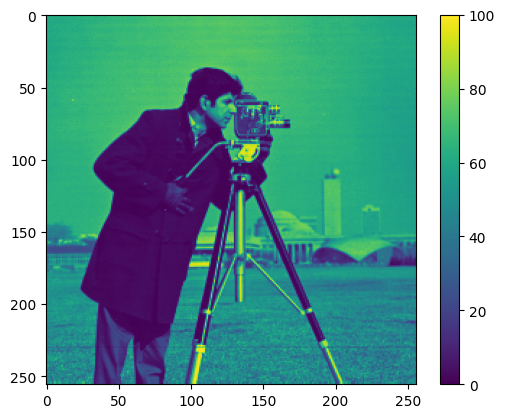

In [5]:
plt.imshow(cameraman)
plt.colorbar()

### Generating and saving the training database.

To generate the training databse, we use the following procedure:
1. Set $c_i \in \{2, 4, 8, 16, 32, 64\}$
2. For each $c_i$, randomly choose 10 numbers $s_{i,j}\in[0.01,0.8]$. With $N = 256\times 256$ the total number of points in the image, set $M_{i,j} = N * s_{i,j}$ as the number of "measured" points.
3. Generate a $256 \times 256$ random measurement mask that indicates the $M_{i,j}$ measured points. The measured values are the values of the cameraman image at these points.
4. For each such measurement mask, calculate the feature vectors and the RDs (the labels) for the unmeasured points. 

With this procedure, we have $\sum_{j} M_{i,j}$ training data points for each  $c_i$. For example, if we have $s_j\in\{0.05,0.12, 0.13, 0.17, 0.31, 0.48, 0.55, 0.59, 0.62, 0.75\}$, then the total number of training data points is:
$$256^2 (0.05 + 0.12 + 0.13 + 0.17 + 0.31 + 0.48 + 0.55 + 0.59 + 0.62 + 075) = 247070$$




In [6]:
train_params = inp.TrainingInputParams(input_images_path=base_path / 'images',
                                   output_dir=base_path, 
                                   num_repeats_per_mask=1,
                                   measurements_per_initial_mask=10,
                                   test_c_values=[2, 4, 8, 16, 32, 64])

In [ ]:
train_data_all = training.generate_training_databases(train_params)

### Example of training data:
1. measurement mask, 
2. the image reconstructed by interpolating the measured points, 
3. and the RDs for the unmeasured points.



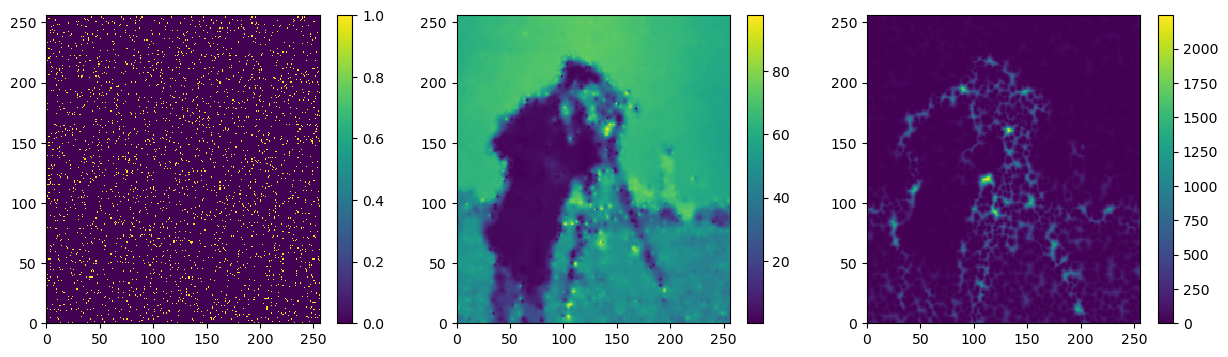

In [10]:
fig, axs = plt.subplots(1,3, figsize=[15, 4])
plt.subplot(1,3,1)
plt.pcolormesh(train_data_all[0].outputs.masks[0][::-1])
plt.colorbar()
plt.subplot(1,3,2)
plt.pcolormesh(train_data_all[0].outputs.recons[0][::-1])
plt.colorbar()
plt.subplot(1,3,3)
plt.pcolormesh(train_data_all[0].outputs.erds[0][::-1])
plt.colorbar()

### Generating the NN model and identifying the optimal value of $c$.

For each value of $c$:
1. Load the training database and split it into (training, validation) sets. 
2. Use the training set to train a multi-layer perceptron model (using sklearn).
3. Using this model, calculate the $R_{squared}$ for the fit of the validation set.

When we choose the value of $c$ with the highest $R_{squared}$, we get $c=2$.

In [11]:
output_path = base_path

In [12]:
val_scores = {}
for c_value in tqdm(train_params.test_c_values):

    print('test c', c_value)

    features_erds_db_path = output_path / Path(f'c_{c_value}') / 'training_database.pkl'

    val_scores[c_value] = []

    save_path = features_erds_db_path.parent / f'erd_model_relu.pkl'
    
    features_all, erds_all = training.get_features_and_erds_from_db(features_erds_db_path)
    train_feat, train_erds, val_feat, val_erds = training.training_validation_split(features_all, erds_all, training_split=0.8,random_seed=111)
    
    erd_model, _ = training.fit_erd_model((train_feat, train_erds),
                                          model_params=inp.SladsModelParams(max_iter=50),
                                          save_path=save_path,
                                          training_split=0.8, 
                                          random_seed = 111)
    score = training.validate_erd_model_r_squared((val_feat, val_erds),
                                                  erd_model_path=save_path,
                                                  random_seed = 111)
    print('R squared score', score)
    val_scores[c_value].append(score)
        
    


  0%|          | 0/1 [00:00<?, ?it/s]

test c 2
Ignoring the features db path and train/val split ratio.Directly loading the training features and erds instead.
Ignoring the features db path and train/val split ratio.Directly loading the features and erds instead.
Validation score is 0.8406675267837258
R squared score 0.8406675267837258


/Users/skandel/.conda/envs/slads/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [70]:
val_scores

{2: [0.844463214124102],
 4: [0.8288802619955977],
 8: [0.5999938134094193],
 16: [0.5894459831579671],
 32: [0.5631287795830058],
 64: [0.6165459329192193]}